## Anggota Kelompok
- Ghulam Mushthofa
- Hasbi Abdullah 
- Muslih Hadi
- Rafii Abdurrahman
- Rafi Aditya

## Deskripsi Tugas
Proyek ini bertujuan untuk mengimplementasikan arsitektur sederhana dari Generative Adversarial Network (GAN) menggunakan dataset MNIST. GAN terdiri dari dua model:
- Generator: menghasilkan gambar digit tangan
- Discriminator: membedakan gambar asli atau buatan

Model dilatih secara bersamaan untuk menghasilkan gambar digit tangan yang realistis.

# Generative Adversarial Network (GAN)

**Pengertian GAN:**  
Generative Adversarial Network (GAN) adalah arsitektur deep learning yang terdiri dari dua model neural network yang saling berkompetisi:
- **Generator (G)**: menghasilkan data palsu yang menyerupai data asli.
- **Discriminator (D)**: membedakan apakah data yang diterima asli atau hasil generator.

**Cara kerja:**  
1. Generator membuat gambar palsu dari noise acak.  
2. Discriminator mengevaluasi gambar tersebut dan memberi label (real atau fake).  
3. Generator belajar memperbaiki hasilnya agar mampu “menipu” Discriminator.  
4. Discriminator juga belajar menjadi lebih baik dalam mendeteksi gambar palsu.  

Proses ini disebut *adversarial training*, karena kedua model berkompetisi dan sama-sama belajar menjadi lebih baik.

**Dataset yang digunakan:**  
- **MNIST:** dataset gambar digit tangan (0-9) ukuran 28x28 piksel.

---


## Import Library utama untuk implementasi GAN

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os


In [14]:
# Hyperparameter
batch_size = 128   # jumlah data per batch
lr = 0.0002        # learning rate
z_dim = 100        # ukuran noise vector untuk generator
epochs = 50        # jumlah epoch training

# Setup device: gunakan GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Membuat folder output jika belum ada
os.makedirs("generated_images", exist_ok=True)
os.makedirs("models", exist_ok=True)


## Menentukan parameter training, memilih GPU untuk mempercepat training, serta membuat folder untuk menyimpan gambar hasil generator dan model terlatih.

In [15]:
# Transformasi dataset: ubah ke tensor dan normalisasi ke range [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download dan load dataset FashionMNIST
dataset = datasets.FashionMNIST(root='.', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


## menggunakan FashionMNIST yang berisi gambar grayscale 28x28 (baju, sepatu, tas). Normalisasi ke [-1,1] karena output generator menggunakan tanh.

In [16]:
# Membuat class Generator
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.model(z)
        return out.view(-1, 1, 28, 28)  # reshape output menjadi (batch, channel, height, width)

# Inisialisasi generator
G = Generator(z_dim).to(device)


## Generator menerima input noise vector dan menghasilkan gambar 28x28 dengan nilai pixel di range [-1,1].

In [17]:
# Membuat class Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # flatten image
        validity = self.model(img_flat)
        return validity

# Inisialisasi discriminator
D = Discriminator().to(device)


## Discriminator bertugas membedakan gambar asli dan gambar palsu yang dihasilkan generator.

In [18]:
# Menggunakan Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Optimizer Adam untuk G dan D
optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)


## Karena GAN adalah masalah binary classification (real vs fake), kita menggunakan BCELoss.

In [19]:
# Set model ke mode training
G.train()
D.train()

# Menyimpan history loss
loss_G_list = []
loss_D_list = []

# Training loop GAN
for epoch in range(1, epochs+1):
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # Label real dan fake
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # =====================
        # Train Discriminator
        # =====================
        z = torch.randn(batch_size, z_dim).to(device)
        gen_imgs = G(z)

        real_loss = criterion(D(imgs), real)
        fake_loss = criterion(D(gen_imgs.detach()), fake)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # =====================
        # Train Generator
        # =====================
        z = torch.randn(batch_size, z_dim).to(device)
        gen_imgs = G(z)
        g_loss = criterion(D(gen_imgs), real)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
    
    # Save loss history
    loss_G_list.append(g_loss.item())
    loss_D_list.append(d_loss.item())

    print(f"Epoch [{epoch}/{epochs}]  D Loss: {d_loss.item():.4f}  G Loss: {g_loss.item():.4f}")

    # Save generated images tiap 10 epoch
    if epoch % 10 == 0:
        gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
        img_grid = gen_imgs[:25].cpu().detach()
        img_grid = img_grid * 0.5 + 0.5  # unnormalize
        plt.figure(figsize=(5,5))
        for k in range(25):
            plt.subplot(5,5,k+1)
            plt.imshow(img_grid[k][0], cmap="gray")
            plt.axis("off")
        plt.savefig(f"generated_images/epoch_{epoch}.png")
        plt.close()


Epoch [1/50]  D Loss: 1.0601  G Loss: 1.2688
Epoch [2/50]  D Loss: 0.0469  G Loss: 4.8843
Epoch [3/50]  D Loss: 0.0846  G Loss: 6.1438
Epoch [4/50]  D Loss: 0.2760  G Loss: 8.7737
Epoch [5/50]  D Loss: 0.3718  G Loss: 12.8757
Epoch [6/50]  D Loss: 0.1381  G Loss: 10.0658
Epoch [7/50]  D Loss: 0.2035  G Loss: 5.7069
Epoch [8/50]  D Loss: 0.6902  G Loss: 5.8491
Epoch [9/50]  D Loss: 0.2655  G Loss: 3.5331
Epoch [10/50]  D Loss: 0.2496  G Loss: 3.5836
Epoch [11/50]  D Loss: 0.7674  G Loss: 5.7659
Epoch [12/50]  D Loss: 0.5060  G Loss: 3.0000
Epoch [13/50]  D Loss: 0.2963  G Loss: 4.2457
Epoch [14/50]  D Loss: 0.4337  G Loss: 4.2558
Epoch [15/50]  D Loss: 0.3800  G Loss: 4.4416
Epoch [16/50]  D Loss: 0.6240  G Loss: 3.6043
Epoch [17/50]  D Loss: 0.6036  G Loss: 4.6323
Epoch [18/50]  D Loss: 0.8174  G Loss: 2.3466
Epoch [19/50]  D Loss: 0.5670  G Loss: 2.4857
Epoch [20/50]  D Loss: 0.7050  G Loss: 2.3732
Epoch [21/50]  D Loss: 0.4985  G Loss: 3.4808
Epoch [22/50]  D Loss: 0.8949  G Loss: 2.

## terdapat dua tahap training di setiap iterasi:

- Training Discriminator dengan gambar asli dan palsu (detach gen_imgs agar gradient tidak mengalir ke G).

- Training Generator dengan tujuan menipu Discriminator agar menganggap gambar palsu sebagai real.

#### Hasil gambar generator disimpan setiap 10 epoch di folder generated_images.

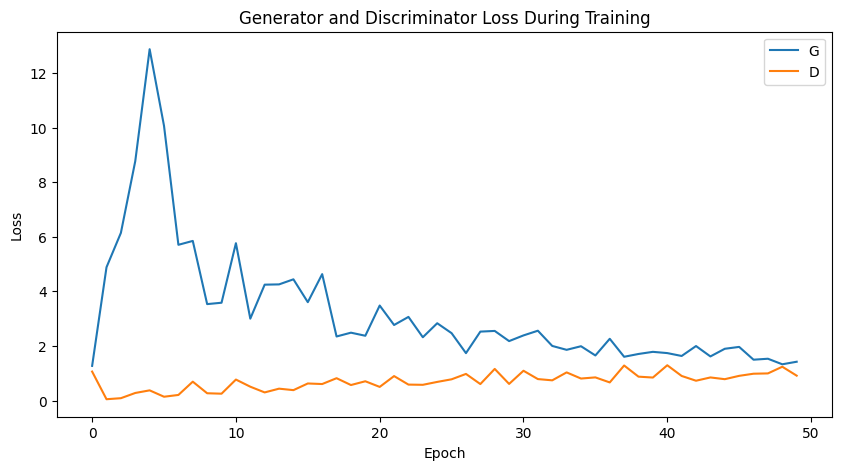

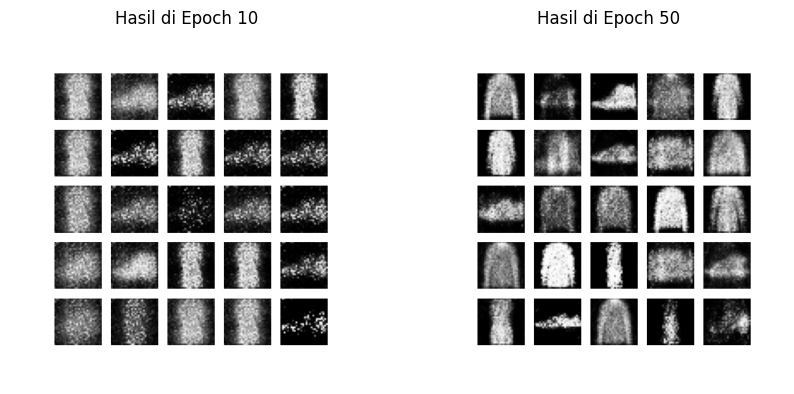

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plot Loss G dan D
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_G_list, label="G")
plt.plot(loss_D_list, label="D")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Menampilkan hasil gambar di epoch awal dan akhir
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Gambar hasil epoch awal
img_awal = mpimg.imread('generated_images/epoch_10.png')
axes[0].imshow(img_awal, cmap='gray')
axes[0].set_title("Hasil di Epoch 10")
axes[0].axis('off')

# Gambar hasil epoch akhir
img_akhir = mpimg.imread(f'generated_images/epoch_{epochs}.png')
axes[1].imshow(img_akhir, cmap='gray')
axes[1].set_title(f"Hasil di Epoch {epochs}")
axes[1].axis('off')

plt.show()


In [21]:
# Menyimpan model generator dan discriminator
torch.save(G.state_dict(), "models/generator.pth")
torch.save(D.state_dict(), "models/discriminator.pth")


## Analisis Hasil dan Kesimpulan

Pada grafik di atas, terlihat bahwa:

- **Loss Generator (G)** pada awal training sangat tinggi karena generator belum mampu menghasilkan gambar realistis. Seiring training, loss generator menurun, meskipun fluktuatif karena sifat training adversarial.
- **Loss Discriminator (D)** relatif stabil setelah epoch awal, menunjukkan bahwa discriminator mampu membedakan gambar real dan fake dengan baik.

### Perbandingan Gambar Epoch Awal vs Akhir
- **Epoch 5:** Gambar masih berupa noise acak, belum terbentuk pola yang menyerupai digit FashionMNIST.
- **Epoch 50:** Gambar sudah mulai menyerupai objek dataset (sepatu, tas, dll) meskipun masih ada noise. Hal ini menunjukkan generator berhasil belajar distribusi data.

---

Secara keseluruhan, GAN yang dilatih pada dataset FashionMNIST ini menunjukkan **progres yang signifikan**, dengan generator menghasilkan gambar yang lebih realistis seiring bertambahnya epoch.


# Refleksi Pribadi
## 1. Tantangan Utama
   
Tantangan utama dalam mengerjakan tugas ini adalah memahami alur implementasi GAN dari awal, mulai dari konsep teorinya, arsitektur generator dan discriminator, hingga training loop yang benar agar tidak terjadi error. Selain itu, memahami bagaimana loss function bekerja dan bagaimana cara menyimpan serta menampilkan hasil generator secara berkala juga membutuhkan waktu untuk benar-benar dipahami.

Selain tantangan teknis, mengatur waktu pengerjaan di antara kesibukan mata kuliah lain juga menjadi kendala tersendiri, terutama karena tugas ini cukup panjang dan detail.

## 2. Pembelajaran Penting
Pembelajaran terpenting dari pengerjaan tugas ini adalah:

- Memahami konsep GAN secara mendasar, bagaimana generator dan discriminator saling berkompetisi dan belajar satu sama lain.
- Mengimplementasikan GAN dengan PyTorch, mulai dari menyiapkan dataset, mendefinisikan model, hingga melatih dan menyimpan hasilnya.
- Pentingnya visualisasi hasil training, karena meskipun loss turun, tanpa mengecek gambar hasil generator kita tidak tahu apakah model benar-benar belajar atau tidak.
- Keterampilan debugging dan troubleshooting, seperti memperbaiki error dimension, normalisasi output, dan penamaan file saat menyimpan hasil.

## 3. Kolaborasi Tim
Pada tugas ini, dibantu oleh ChatGPT untuk memahami teori dan struktur kode dengan lebih mudah. Anggota lain berkontribusi secara teknis pada pengerjaan kode dan lain-lain.

Namun ke depannya, kita belajar bahwa akan lebih baik jika sejak awal:

Membagi tugas per bagian, misalnya:

- Muslih Hadi: Teori dan markdown awal

- Ghulam Mushthofa: Implementasi generator dan discriminator

- Hasbi Abdullah dan Rafi Aditya: Training loop dan visualisasi

- Rafii Abdurrahman: Penyusunan README.md dan finalisasi

Mengadakan pertemuan singkat daring untuk memastikan semua anggota memahami alur tugas.

Menjelaskan kepada tim pentingnya kontribusi di GitHub untuk memenuhi kriteria penilaian kolaborasi.

